In [7]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting

In [8]:
import hcp_utils as hcp

# Load connectome data

In [3]:
#Load connectomes

#feat_file = '/mnt/c/Users/liz/Contacts/Desktop/course-materials-2020/fMRI_HCP/features_11Subs.npz'
feat_file = '/mnt/c/Users/liz/Contacts/Desktop/course-materials-2020/fMRI_HCP/all_features_47.npz'

X_features = np.load(feat_file)['a']

In [4]:
X_features.shape

(47, 7, 7)

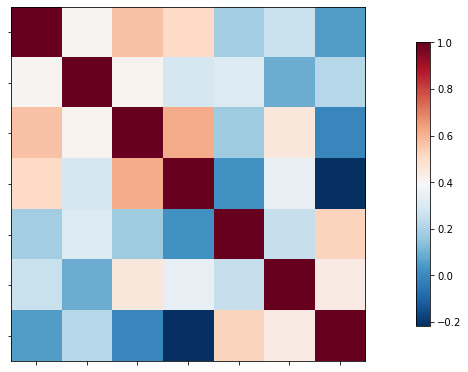

In [5]:
#Example how it looks for one subject
correlation_matrix = X_features[0]
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix)

In [11]:
#subject IDs of the connectome data 
with open('subID_47.txt', 'r') as f:
    subjects_connectome = json.loads(f.read())
    
subjects_connectome

['100307',
 '100408',
 '101107',
 '101309',
 '101915',
 '103111',
 '103414',
 '103818',
 '105014',
 '105115',
 '106016',
 '108828',
 '110411',
 '111312',
 '111716',
 '113619',
 '113922',
 '114419',
 '116524',
 '117122',
 '118528',
 '118730',
 '118932',
 '122317',
 '122620',
 '123117',
 '123925',
 '124422',
 '125525',
 '126325',
 '127630',
 '127933',
 '128127',
 '128632',
 '129028',
 '130013',
 '130316',
 '131217',
 '131722',
 '133019',
 '133928',
 '135225',
 '135932',
 '136833',
 '138534',
 '139637',
 '140925']

In [102]:
subjects_connectome = list(map(int, subjects_connectome))
print(subjects_connectome)

[100307, 100408, 101107, 101309, 101915, 103111, 103414, 103818, 105014, 105115, 106016, 108828, 110411, 111312, 111716, 113619, 113922, 114419, 116524, 117122, 118528, 118730, 118932, 122317, 122620, 123117, 123925, 124422, 125525, 126325, 127630, 127933, 128127, 128632, 129028, 130013, 130316, 131217, 131722, 133019, 133928, 135225, 135932, 136833, 138534, 139637, 140925]


# Load behavioral data 

In [176]:
#Load clean behavioral data 
#behavior = pd.read_csv("/mnt/c/Users/liz/Contacts/Desktop/course-materials-2020/fMRI_HCP/HCP_behavioralData.csv")

behavior = pd.read_csv("/mnt/c/Users/liz/Contacts/Desktop/course-materials-2020/fMRI_HCP/HCP_behavior_includeZscores.csv")

In [177]:
print(behavior.shape)
behavior.head()

(844, 573)


,Unnamed: 0,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,...,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f
0,1,100206,S900,Q11,M,26-30,True,1,1,4,...,72.63,72.03,1.84,0.0,1.84,0.053852,-1.649623,1.435010,3,3.084632
1,2,100307,Q1,Q01,F,26-30,True,1,1,4,...,71.69,71.76,1.76,0.0,1.76,-0.120580,-0.720448,-0.031687,0,0.688761
2,3,100408,Q3,Q03,M,31-35,True,1,1,4,...,114.01,113.59,1.76,2.0,1.68,-0.295012,-0.329899,1.130657,3,1.460556
3,8,101309,S500,Q06,M,26-30,True,1,1,4,...,106.39,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402
4,9,101410,S500,Q06,M,26-30,False,2,1,2,...,73.86,71.78,1.80,0.0,1.80,-0.033364,-0.628364,-0.163840,0,0.464524


In [178]:
#Take only the connectome subjects from the behavior data
behavior_clean = behavior.loc[behavior['Subject'].isin(subjects_connectome)]
behavior_clean.shape

(42, 573)

In [179]:
print(behavior_clean.shape)
behavior_clean.head()

(42, 573)


,Unnamed: 0,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,...,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f
1,2,100307,Q1,Q01,F,26-30,True,1,1,4,...,71.69,71.76,1.76,0.0,1.76,-0.120580,-0.720448,-0.031687,0,0.688761
2,3,100408,Q3,Q03,M,31-35,True,1,1,4,...,114.01,113.59,1.76,2.0,1.68,-0.295012,-0.329899,1.130657,3,1.460556
3,8,101309,S500,Q06,M,26-30,True,1,1,4,...,106.39,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402
5,11,101915,Q3,Q04,F,31-35,True,2,2,4,...,112.11,111.70,1.84,1.0,1.80,-0.033364,1.454413,-1.313170,1,2.767582
11,20,103111,S500,Q06,M,26-30,True,1,1,4,...,109.15,107.30,1.80,0.0,1.80,-0.033364,0.434079,-0.738505,1,1.172584


In [180]:
#Set subject as index
behavior_clean = behavior_clean.set_index('Subject')
behavior_clean

,Unnamed: 0,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,z_score_mars,z_score_DDisc_AUC,z_score_Flanker,GroupType_f,z_score_compare_f
Subject,,,,,,,,,,,,,,,,,,,,,
100307,2,Q1,Q01,F,26-30,True,1,1,4,100.0,...,71.69,71.76,1.76,0.0,1.76,-0.120580,-0.720448,-0.031687,0,0.688761
100408,3,Q3,Q03,M,31-35,True,1,1,4,100.0,...,114.01,113.59,1.76,2.0,1.68,-0.295012,-0.329899,1.130657,3,1.460556
101309,8,S500,Q06,M,26-30,True,1,1,4,100.0,...,106.39,104.39,1.80,0.0,1.80,-0.033364,1.547886,0.115483,2,1.432402
101915,11,Q3,Q04,F,31-35,True,2,2,4,100.0,...,112.11,111.70,1.84,1.0,1.80,-0.033364,1.454413,-1.313170,1,2.767582
103111,20,S500,Q06,M,26-30,True,1,1,4,100.0,...,109.15,107.30,1.80,0.0,1.80,-0.033364,0.434079,-0.738505,1,1.172584
103414,22,Q2,Q02,F,22-25,True,1,1,4,100.0,...,91.50,89.45,1.76,0.0,1.76,-0.120580,1.250346,-1.100924,1,2.351270
103818,24,Q1,Q01,F,31-35,True,2,2,4,100.0,...,90.63,87.88,1.88,1.0,1.84,0.053852,-0.056421,-0.996804,0,0.940382
105014,29,S500,Q05,F,26-30,True,2,2,4,100.0,...,73.86,72.70,1.80,0.0,1.80,-0.033364,-0.007371,-1.617522,0,1.610150
105115,30,Q2,Q02,M,31-35,True,2,2,4,100.0,...,93.82,91.19,1.76,0.0,1.76,-0.120580,0.271659,-0.446167,1,0.717825


In [181]:
behavior_clean.index

Int64Index([100307, 100408, 101309, 101915, 103111, 103414, 103818, 105014,
            105115, 106016, 108828, 110411, 111312, 111716, 113619, 113922,
            114419, 117122, 118932, 122317, 122620, 123117, 123925, 124422,
            125525, 126325, 127630, 128127, 128632, 129028, 130013, 130316,
            131217, 131722, 133019, 133928, 135225, 135932, 136833, 138534,
            139637, 140925],
           dtype='int64', name='Subject')

In [182]:
all_fc_data.index

Int64Index([100307, 100408, 101107, 101309, 101915, 103111, 103414, 103818,
            105014, 105115, 106016, 108828, 110411, 111312, 111716, 113619,
            113922, 114419, 116524, 117122, 118528, 118730, 118932, 122317,
            122620, 123117, 123925, 124422, 125525, 126325, 127630, 127933,
            128127, 128632, 129028, 130013, 130316, 131217, 131722, 133019,
            133928, 135225, 135932, 136833, 138534, 139637, 140925],
           dtype='int64')

# Prepare x_features to the model

In [194]:
#Create the wanted connectivity matrix
from nilearn import connectome
#kind{“correlation”, “partial correlation”, “tangent”, “covariance”, “precision”}
correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
correlation_measure

ConnectivityMeasure(kind='correlation')

In [195]:
#Reduce to half of the matrix and discrad diagonal - example on one subject
vectorized_correlation = connectome.ConnectivityMeasure(kind='correlation',
                                                        vectorize=True, discard_diagonal=True)
clean_vectorized_correlation = vectorized_correlation.fit_transform([correlation_matrix])[0]
clean_vectorized_correlation.shape  # num_nodes*(num_nodes-1)/2

(21,)

In [196]:
#Reduce to half of the matrix and discrad diagonal - for each subject
clean_connectivity_data = []
#print(data[1])
for i in range(len(X_features)):
    print(i)
    #print (X_features[i])
    clean_connectivity_data.append(vectorized_correlation.fit_transform([X_features[i]])[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [197]:
len(clean_connectivity_data)

47

In [198]:
#convert list to dataframe
all_fc_data  = pd.DataFrame(clean_connectivity_data, index = subjects_connectome)

In [191]:
behavior_clean.index

Int64Index([100307, 100408, 101309, 101915, 103111, 103414, 103818, 105014,
            105115, 106016, 108828, 110411, 111312, 111716, 113619, 113922,
            114419, 117122, 118932, 122317, 122620, 123117, 123925, 124422,
            125525, 126325, 127630, 128127, 128632, 129028, 130013, 130316,
            131217, 131722, 133019, 133928, 135225, 135932, 136833, 138534,
            139637, 140925],
           dtype='int64', name='Subject')

In [199]:
#Take the same subjects as in the behavior data
all_fc_data = all_fc_data[all_fc_data.index.isin(behavior_clean.index)]
all_fc_data.shape

(42, 21)

In [200]:
print(all_fc_data.shape)
all_fc_data

(42, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
100307,0.150703,0.413017,0.078796,0.407994,0.026201,0.509495,-0.374281,-0.057324,-0.431548,-0.483916,...,-0.446835,0.053457,-0.002642,-0.116779,-0.471974,-0.170191,-0.526139,-0.600055,0.417405,0.136561
100408,0.535389,0.435199,0.452204,0.312155,0.384608,0.548645,-0.092251,-0.082397,-0.332387,-0.355664,...,-0.523611,-0.273256,-0.192014,-0.251189,-0.140242,-0.198745,-0.491566,-0.563415,0.334962,0.014801
101309,0.390712,0.321339,0.393539,0.360942,0.384673,0.499286,-0.189840,-0.109190,-0.226156,-0.236461,...,-0.315602,-0.020435,-0.053182,-0.237730,-0.312702,-0.361367,-0.500350,-0.532428,0.119091,0.006014
101915,0.376462,0.387888,0.374506,0.247279,0.219972,0.354402,-0.121716,-0.070643,-0.214635,-0.354294,...,-0.458212,-0.238863,-0.221112,-0.052378,-0.255186,-0.275961,-0.428140,-0.563801,0.263301,0.264113
103111,0.231808,0.450507,0.322671,0.381889,0.444888,0.576614,-0.465893,-0.357018,-0.466504,-0.477571,...,-0.141808,-0.008530,-0.027832,-0.050090,-0.486852,-0.350343,-0.586289,-0.576691,0.346566,0.155075
103414,0.067575,0.389833,0.246716,0.354462,0.376347,0.538318,-0.402278,-0.159660,-0.503969,-0.466957,...,-0.470584,-0.001467,-0.166584,-0.162937,-0.354414,-0.369927,-0.606102,-0.603473,0.438395,0.102011
103818,0.313591,0.395154,0.155305,0.228207,0.183692,0.527276,-0.169011,-0.117696,-0.426518,-0.506533,...,-0.478862,-0.285839,-0.290087,0.092053,-0.287124,-0.146388,-0.608243,-0.627477,0.432703,0.310216
105014,0.241953,0.270933,0.334389,0.156944,0.301531,0.360124,-0.085245,-0.063032,-0.232996,-0.339495,...,-0.278694,-0.017017,0.028477,-0.339048,-0.122932,-0.254793,-0.398965,-0.444913,0.282026,-0.109194
105115,0.071788,0.188549,0.012953,0.310981,0.152190,0.357095,-0.389337,-0.070676,-0.319489,-0.390579,...,-0.188686,0.145253,-0.064151,-0.006447,-0.398772,-0.096321,-0.441776,-0.481774,0.381535,0.089784
106016,0.434045,0.445059,0.404733,0.430516,0.364730,0.428225,-0.423750,-0.315524,-0.451327,-0.449548,...,-0.067933,0.254748,0.138351,-0.392635,-0.332816,-0.375876,-0.449697,-0.465876,0.218121,-0.024719


AttributeError: module 'matplotlib' has no attribute 'show'

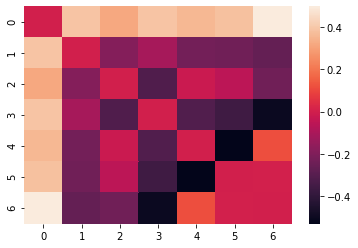

In [201]:
s = 2

sns.heatmap(sp.spatial.distance.squareform(all_fc_data.iloc[s,:]))
plt.show()

# Define CPM functions

In [202]:
subj_list = behavior_clean.index 

In [203]:

def mk_kfold_indices(subj_list, k = 3):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [204]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [205]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [206]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [207]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [208]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

In [209]:
def cpm_wrapper(all_fc_data, all_behav_data, behav, k=3, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks        

AttributeError: module 'matplotlib' has no attribute 'show'

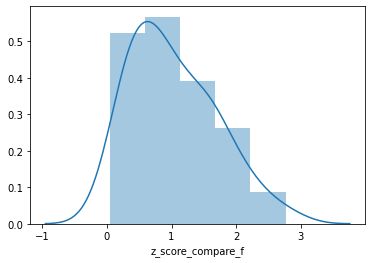

In [210]:
#behav = 'Flanker_AgeAdj'

behav = 'z_score_compare_f'

sns.distplot(behavior_clean[behav])
plt.show()

In [211]:
cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, behavior_clean, behav=behav, **cpm_kwargs)

doing fold 0
doing fold 1


/home/lizakson/miniconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [127]:
behav_obs_pred.head()

,Flanker_AgeAdj predicted (pos),Flanker_AgeAdj predicted (neg),Flanker_AgeAdj predicted (glm),Flanker_AgeAdj observed
100307,100.191,103.759,102.189,101.9
100408,96.8641,99.9314,94.7975,113.51
101107,105.357,107.374,107.205,96.19
101309,99.9672,100.591,98.5256,103.37
101915,103.077,103.147,103.399,89.1


In [128]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
    
    r = sp.stats.pearsonr(x,y)[0][0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

TypeError: No loop matching the specified signature and casting was found for ufunc add

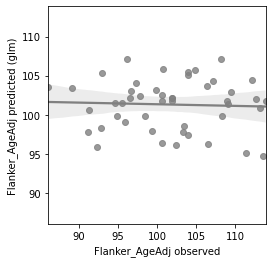

In [129]:
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()